# Planetary Nebula Production <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pnlf` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# this imports packages like numpy or astropy 
from pnlf.packages import *
# constants that are used across multiple functions
from pnlf.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,format='%(levelname)s: %(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# first we need to specify the path to the raw data
basedir = Path('..')
data_raw = basedir / 'data' / 'raw' / 'MUSE' / 'DR2'
data_ext = Path('g:\Archive')

# table to save all results
results = ascii.read(basedir/'data'/'interim'/ 'results.txt',format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
results.add_index('name')    

sample_table = ascii.read(basedir/'data'/'interim'/'sample.txt')
sample_table.add_index('Name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])

### Read in data

this uses the `ReadLineMaps` class from the `pnlf.io` module. To use it, we first need to specify the path to the data folder

IC5332, NGC628, NGC1087, NGC1365, NGC1512, NGC1566, NGC1672, NGC2835, NGC3351, NGC3627, NGC4254, NGC4535, NGC5068

In [3]:
from pnlf.io import ReadLineMaps

name = 'IC5332'

with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw/'MUSEDAP',name,**parameters[name])
galaxy.center = sample_table.loc[name]['SkyCoord'].to_pixel(galaxy.wcs)
galaxy.Ebv = sample_table.loc[name]['E(B-V)']
galaxy.posang = sample_table.loc[name]['posang']
galaxy.inclination = sample_table.loc[name]['Inclination']
galaxy.r25 = sample_table.loc[name]['r25']

INFO: loading IC5332
INFO: replacing OIII5006 map
INFO: file loaded with 5 extensions


### Mask unwanted regions

Galaxies with mask
NGC1300,NGC1512,NGC1566,NGC1672,NGC3351,NGC3627,NGC4303,NGC4321,NGC4535

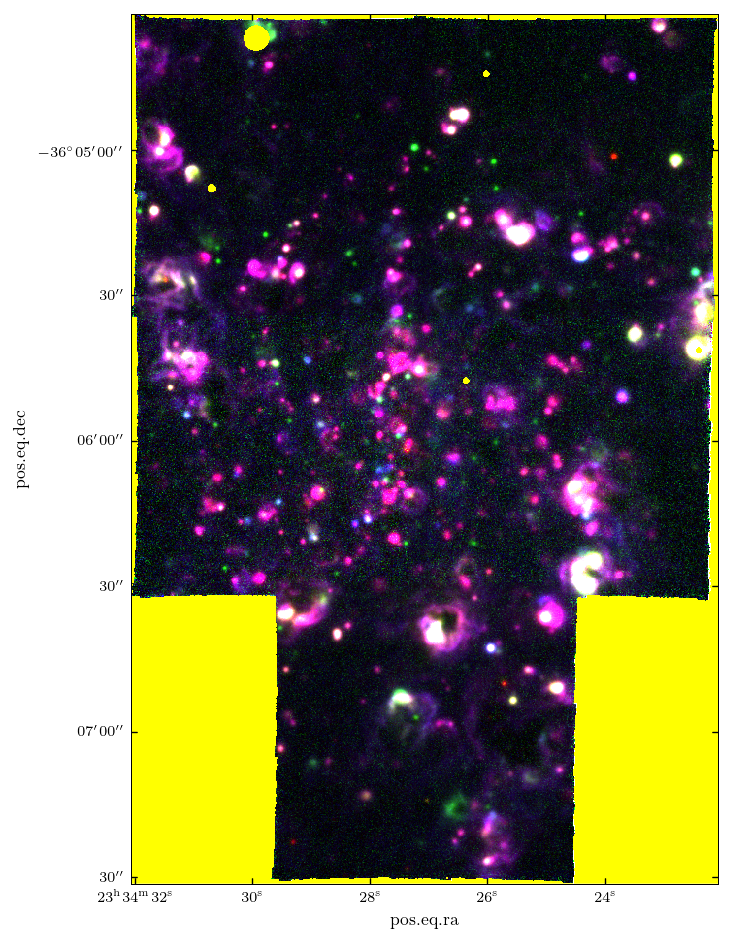

In [4]:
from pnlf.plot.plot import create_RGB
from regions import PixCoord,EllipsePixelRegion

eccentricity = np.sin(galaxy.inclination*u.deg).value
# angle uses x-axis but posang is defined from north pole (y-axis)
aperture = EllipsePixelRegion(PixCoord(*galaxy.center),
                              width=galaxy.r25,
                              height=np.sqrt((galaxy.r25)**2 * (1-eccentricity**2)),
                              angle=(galaxy.posang-90)*u.deg)
center_mask = aperture.to_mask().to_image(galaxy.shape).astype(bool)

mask = np.zeros(galaxy.shape,dtype=bool)
mask |= galaxy.star_mask.astype(bool)
if hasattr(galaxy,'mask'):
    print('masking parts of the image')
    mask[galaxy.HA6562>getattr(galaxy,'HAmask',np.nanpercentile(galaxy.HA6562,95))]=True
    mask |=center_mask

img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])
img[mask,...] = (1,1,0.)

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection=galaxy.wcs)
ax.imshow(img,origin='lower')
plt.show()

## Source Detection

we use the DAP maps because they should have a better signal to noise

In [5]:
from photutils import DAOStarFinder            # DAOFIND routine to detect sources
from photutils import IRAFStarFinder           # IRAF starfind routine to detect star
from pnlf.detection import detect_unresolved_sources

In [6]:
sources = detect_unresolved_sources(galaxy,
                                    'OIII5006_DAP',
                                    StarFinder=DAOStarFinder,
                                    threshold=galaxy.threshold,
                                    exclude_region=mask,
                                    oversize=1.,
                                    roundlo=-1,
                                    roundhi=1,
                                    sharplo=0,
                                    sharphi=1,
                                    save=False)

INFO: masking 18.32 % of the image
INFO: searching for sources in IC5332 with [OIII5006_DAP] line map (using DAOStarFinder)

INFO: roundlo: -1 ,roundhi: 1 ,sharplo: 0 ,sharphi: 1 
INFO: searching for sources in 5 pointings
INFO:      fwhm   #N    mean  median     std
INFO:   2.975px  500  48.157  40.231  45.618
INFO:   3.335px  385  25.001  16.450  28.179
INFO:   3.600px  411  32.103  25.113  32.583
INFO:   3.755px  168  34.667  27.316  33.260
INFO:   3.990px  204  56.000  45.621  51.481
INFO:   total   1668


## Completeness limit

In [ ]:
from pnlf.detection import completeness_limit

In [ ]:
print(f'for {galaxy.name}')
mock_sources = completeness_limit(
                    galaxy,
                    'OIII5006_DAP',
                    DAOStarFinder,
                    threshold=galaxy.threshold,
                    iterations=5,
                    stars_per_mag=50,
                    exclude_region=mask,
                    roundlo=-galaxy.roundness,
                    roundhi=galaxy.roundness,
                    sharplo=galaxy.sharplo,
                    sharphi=galaxy.sharphi,
                    exclude_border=True,
                    plot=False
                                 )

In [ ]:
for x_std in np.unique(mock_sources['x_stddev']):
    sub_sample = mock_sources[mock_sources['x_stddev']==x_std]
    
    for a in np.unique(sub_sample['amplitude']):
        sub_sub = sub_sample[sub_sample['amplitude']==a]

        found = np.sum(sub_sub['sep']<0.5)
        total = len(sub_sub)
        print(f'a={a:.2f}: {found} of {total} recovered ({found/total*100:.2f})')
        
    print(30*'-')

## Flux measurement

In the previous step we detected potential PN candidates by their [OIII] emission. This means we know their position but lack exact flux measurments. In this section we measure the flux of the identified objects in different emission lines that are used in later steps. 

In [7]:
from pnlf.photometry import measure_flux 

In [186]:
Rv  = 3.1
aperture_size = 2.5 #galaxy.aperturesize

flux = measure_flux(galaxy,
                    sources,
                    alpha=galaxy.power_index,
                    Rv=Rv,
                    Ebv=galaxy.Ebv,
                    extinction='MW',
                    background='local',
                    aperture_size=aperture_size)

# calculate magnitudes from measured fluxes
flux['mOIII'] = -2.5*np.log10(flux['OIII5006']*1e-20) - 13.74
flux['dmOIII'] = np.abs( 2.5/np.log(10) * flux['OIII5006_err'] / flux['OIII5006'] )

INFO: measuring fluxes in IC5332 for 1668 sources
aperture = 2.5 fwhm
INFO: measuring fluxes in [OIII5006] line map
INFO: measuring fluxes in [HA6562] line map
INFO: measuring fluxes in [NII6583] line map
INFO: measuring fluxes in [SII6716] line map
INFO: measuring fluxes in [SII6730] line map
INFO: lambda5006: Av=0.05
INFO: all flux measurements completed


## Emission line diagnostics    

to estimate the real uncertainty (error is underestimated by 1.58 for the entire sample)
```
from pnlf.analyse import estimate_uncertainties_from_SII

std = estimate_uncertainties_from_SII(nebulae,plot=True)
```

In [187]:
from pnlf.analyse import emission_line_diagnostics

print(f'emission line diagnostics for {galaxy.name}')
tbl = emission_line_diagnostics(flux,galaxy.mu,galaxy.completeness_limit) 

# create additional columns that are needed for the classification
tbl['sharp'] = sources['sharpness']
tbl['round'] = sources['roundness2']
tbl['SkyCoord'] = SkyCoord.from_pixel(tbl['x'],tbl['y'],galaxy.wcs)
tbl['exclude'] = False
tbl['overluminous'] = False

slow  = .2 #galaxy.sharplo  
shigh = 1. #galaxy.sharphi 
r     = .8 #galaxy.roundness 

# table contains all detected objects. here we mask all undesired objects.
c_shape = ((tbl['sharp']>slow) & (tbl['sharp']<shigh) & (np.abs(tbl['round'])<r)) 
c_PN    = (tbl['type']=='PN')
c_SNR   = (tbl['SNRorPN'] & (tbl['type']=='SNR'))
c_detec = tbl['OIII5006_detection'] 
c_limit = (tbl['mOIII']<galaxy.completeness_limit) 

dPSF = getattr(galaxy,'dPSF',0.122)
# we underestimate the errors. This value comes from a theoreticla SII ratio (see function)
tbl['dmOIII'] *= 1.58
tbl['dmOIII'] = np.sqrt(tbl['dmOIII']**2 + dPSF**2)

emission line diagnostics for IC5332
INFO: 1668 entries in initial catalogue
INFO: using mu=29.78, cl=28
INFO: 1424 objects below the completness limit of 28
INFO: 0 objects classified as 4<log [OIII]/Ha
INFO: 178 (127) objects classified as HII
INFO: 121 (61) objects classified as SNR
INFO: 568 (56) objects classified as PN


### Account for PSF uncertainty

In [171]:
class DisableLogger():
    def __enter__(self):
       logging.disable(logging.CRITICAL)
    def __exit__(self, exit_type, exit_value, exit_traceback):
       logging.disable(logging.NOTSET)
        
def est_err(tbl):
    '''estimate the flux error resulting from an uncertainy PSF
    
    The fwhm of the PSF is difficult to measure and the values we and for
    the values we use we assume an uncertainty of dFWHM = 0.1" = 0.5 px.
    '''
    tbl = tbl.copy()
    delta = 0.5
    aperture_size = 2.5
    
    with DisableLogger():
        
        print('using measured PSF')
        flux1 = measure_flux(galaxy,tbl,alpha=galaxy.power_index,Rv=3.1,Ebv=galaxy.Ebv,
                            extinction='MW',background='local',aperture_size=aperture_size)
        mOIII = -2.5*np.log10(flux1['OIII5006']*1e-20) - 13.74

        print(f'using PSF-{delta}')
        tbl['fwhm'] -= delta
        flux3 = measure_flux(galaxy,tbl,alpha=galaxy.power_index,Rv=3.1,Ebv=galaxy.Ebv,
                            extinction='MW',background='local',aperture_size=aperture_size)
        mOIIIm = -2.5*np.log10(flux3['OIII5006']*1e-20) - 13.74
        
        print(f'using PSF+{delta}')
        tbl['fwhm'] += 2*delta
        flux2 = measure_flux(galaxy,tbl,alpha=galaxy.power_index,Rv=3.1,Ebv=galaxy.Ebv,
                            extinction='MW',background='local',aperture_size=aperture_size)
        mOIIIp = -2.5*np.log10(flux2['OIII5006']*1e-20) - 13.74

 
    
    print(f'PSF-(PSF+delta): {np.nanmean(mOIII[mOIII<28]-mOIIIp[mOIII<28]):.3f}')
    print(f'PSF-(PSF-delta): {np.nanmean(mOIII[mOIII<28]-mOIIIm[mOIII<28]):.3f}')
    print(f'(PSF-delta)+(PSF-delta): {np.nanmean(mOIIIm[mOIII<28]-mOIIIp[mOIII<28])/2:.3f}')

    return mOIII,mOIIIp,mOIIIm

mOIII,mOIIIp,mOIIIm = est_err(sources)
dPSF = np.nanmean(mOIIIm-mOIIIp)/2
dPSF

using measured PSF
using PSF-0.5
using PSF+0.5
PSF-(PSF+delta): 0.159
PSF-(PSF-delta): -0.239
(PSF-delta)+(PSF-delta): 0.200


0.0806602783660291

### Visually inspect objects

plotting RGB+profile for 20 objects


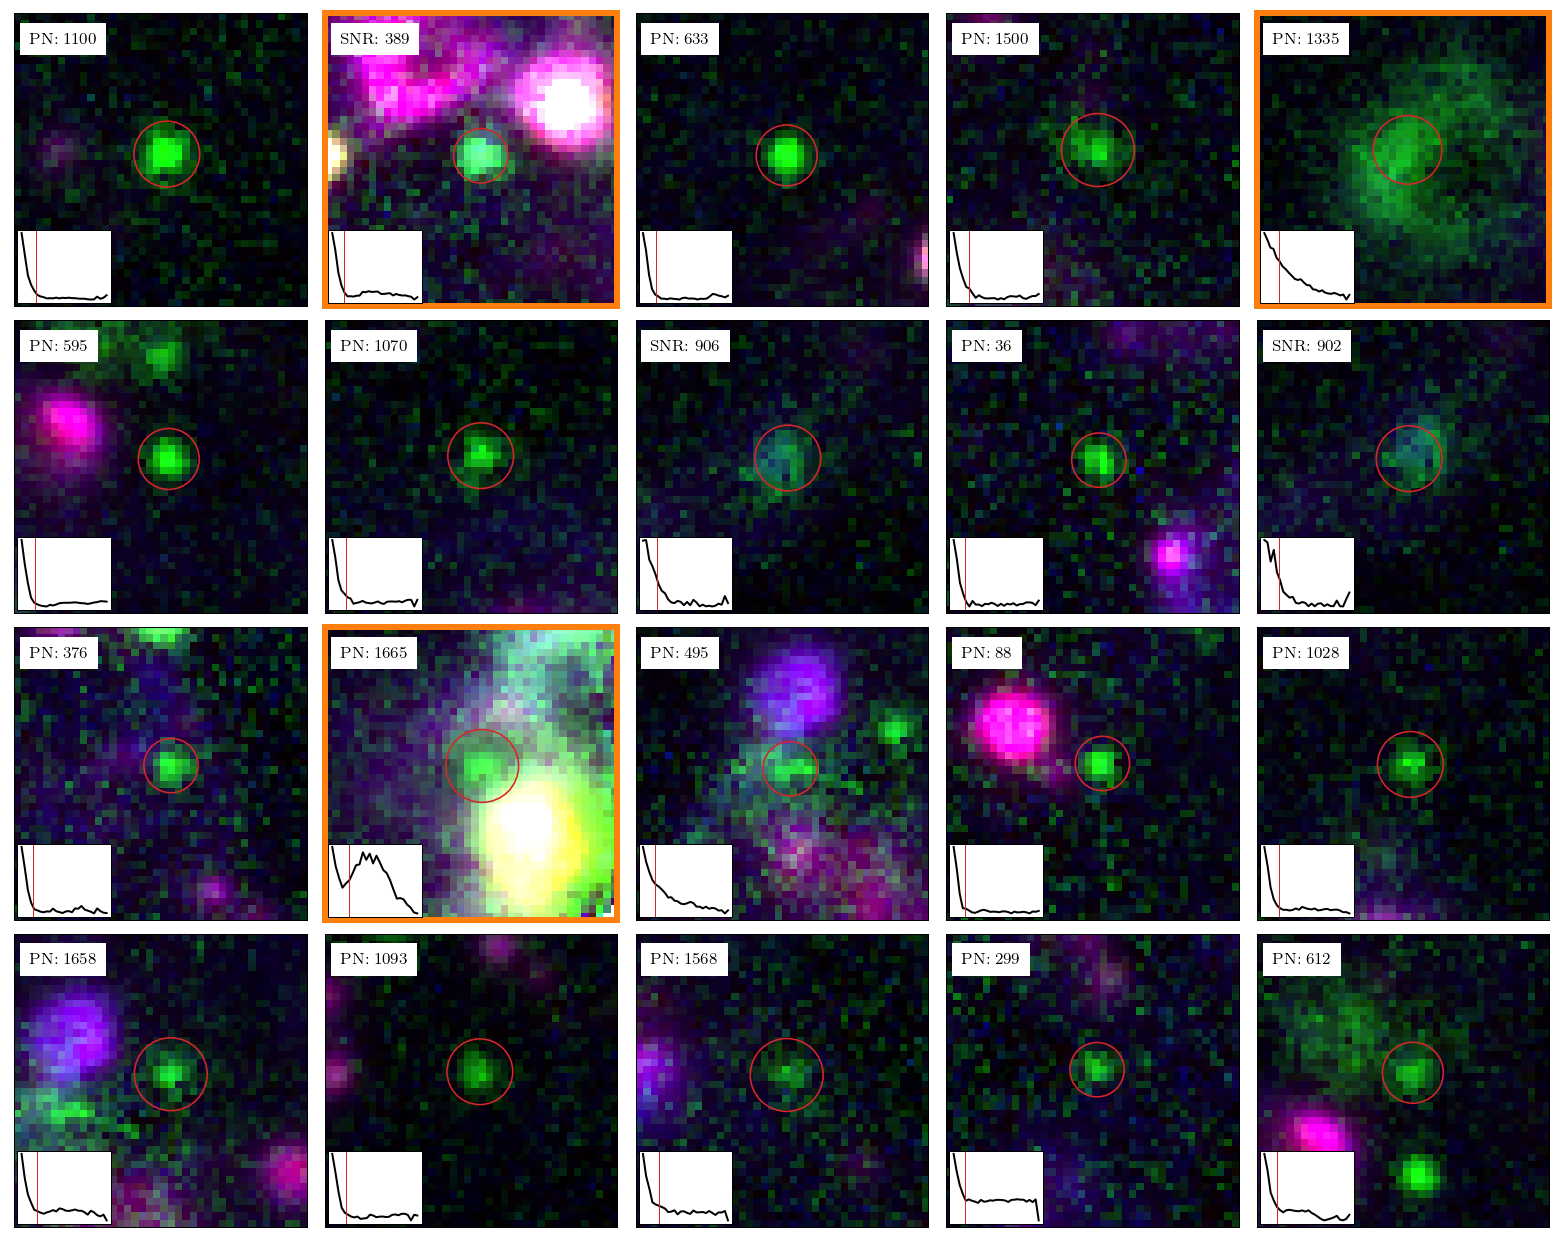

In [189]:
from pnlf.plot.plot import cutout_with_profile

tmp = tbl[c_shape & (c_PN|c_SNR) & c_detec].copy()
tmp.sort('mOIII')

filename = basedir / 'reports' / name / f'{name}_growth_curve'
cutout_with_profile(galaxy,table=tmp[:20],size=40,diagnostics=False,filename=filename)


In [188]:
# remove all objects defined here from the sample
# define masks as slices
exclude = {
 'IC5332'  : [389,1665,1335,618,538,615,876,665],
 'NGC0628' : [882,307,527],
 'NGC1300' : [2796,1863,2779],
 'NGC1365' : [824,1110,996,176,1169,803],
 'NGC1512' : [308,303,1508,3329],
 'NGC1566' : [26,549,376,206,119,717,1013,4,398,328],
 'NGC1672' : [203,211,124,198,138],
 'NGC2835' : [673,178,788,276,416],
 'NGC4254' : [623,473,1072,1938,994],
 'NGC4303' : [381,421],
 'NGC4321' : [2111],
 'NGC5068' : [500,318,295,567],
 'NGC7496' : [131,464,569,126,550,438]
}

overluminous = {
 'NGC1300' : [3165,3285,1689],
 'NGC1433' : [4942,4648],
 'NGC1512' : [397,12],
 'NGC7496' : [318,575]
}

indices = np.where(np.in1d(tbl['id'], exclude.get(galaxy.name,[])))[0]
tbl['exclude'][indices]=True
indices = np.where(np.in1d(tbl['id'], overluminous.get(galaxy.name,[])))[0]
tbl['overluminous'][indices]=True

## Planetary nebula luminosity function

**error budget:**

* PSF shape: power index +- 0.1 -> mu+-0.01
             FWHM += 0.1 px -> mu+-0.02
* Photometry: mu+-0.04

analysing IC5332 (sample table: 29.56)
completeness limit = 28, binsize = 0.4
INFO: initialize fitter with 41 data points
INFO: 29.735+0.110-0.219
8.85 Mpc + 0.45 Mpc - 0.89 Mpc
IC5332: statistic=0.128, pvalue=0.482


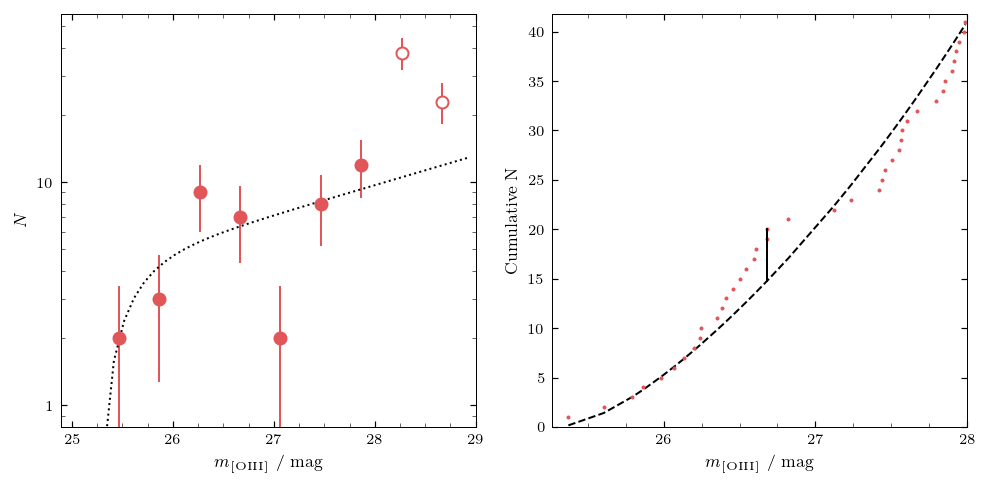

In [190]:
from pnlf.analyse import MaximumLikelihood1D, pnlf, cdf
from pnlf.plot.pnlf import plot_pnlf
from pnlf.auxiliary import mu_to_parsec
from scipy.stats import kstest

binsize = 0.4 #galaxy.binsize

criteria = c_shape & (c_PN) & c_detec & ~tbl['exclude'] & ~tbl['overluminous']
data = tbl[np.where(criteria & c_limit)]['mOIII']
err = tbl[np.where(criteria & c_limit)]['dmOIII']

print(f'analysing {galaxy.name} (sample table: {parameters[name]["mu"]})')
print(f'completeness limit = {galaxy.completeness_limit}, binsize = {binsize}')
fitter = MaximumLikelihood1D(pnlf,data,err=err,mhigh=galaxy.completeness_limit,Mmax=-4.47)
galaxy.mu,mu_p,mu_m = fitter([29])
#mu_p, mu_m = [np.sqrt(err_m**2+np.nanmean(err)**2+dPSF**2) for err_m in [mu_p, mu_m]]

d,(dp,dm)=mu_to_parsec(galaxy.mu,[mu_p,mu_m])
print('{:.2f} + {:.2f} - {:.2f}'.format(d,dp,dm))

#Plot PNLF
filename = basedir / 'reports' / f'{galaxy.name}' / f'{galaxy.name}_PNLF'
axes = plot_pnlf(tbl[criteria]['mOIII'],galaxy.mu,galaxy.completeness_limit,
                 binsize=binsize,mhigh=29,filename=filename,color=tab10[0])

ks,pv = kstest(data,cdf,args=(galaxy.mu,galaxy.completeness_limit))
print(f'{galaxy.name}: statistic={ks:.3f}, pvalue={pv:.3f}')

### Compare to literature

IC5332


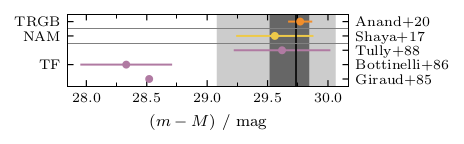

In [191]:
from pnlf.plot.pnlf import compare_distances
print(galaxy.name)
filename = basedir / 'reports' / galaxy.name / f'{galaxy.name}_distances'
distances = compare_distances(galaxy.name,galaxy.mu,mu_p,mu_m,filename=filename)

### Save catalogue to file

In [192]:
from pnlf.io import write_table

filename = basedir / 'data' / 'catalogues' 
t = write_table(tbl[c_shape &  c_detec & c_limit & ~tbl['exclude']],galaxy.name,filename)

INFO: table saved to files (for IC5332)


In [193]:
# this saves the entire table  
tbl_out = tbl[c_shape & (tbl['type']!='NaN') & c_detec]
skycoord = SkyCoord.from_pixel(tbl_out['x'],tbl_out['y'],galaxy.wcs)
tbl_out['RaDec'] = skycoord.to_string(style='hmsdms',precision=2)

for col in tbl_out.colnames:
    if col not in ['id','RaDec','type','SNRorPN','SkyCoord']:
        if not col.endswith('detection'):
            tbl_out[col].info.format = '%.3f' 
            
filename = basedir / 'data' / 'catalogues' / f'{galaxy.name}_nebulae.txt'

with open(filename,'w',newline='\n') as f:
    ascii.write(tbl_out,f,format='fixed_width_two_line',overwrite=True,delimiter_pad=' ',position_char='=')
print(f'{len(tbl_out)} objects saved to ' + str(filename))   

306 objects saved to ..\data\catalogues\IC5332_nebulae.txt


### Visualize the result of the classification

In [ ]:
from pnlf.plot.pnlf import plot_emission_line_ratio

for t in ['PN','SNR','HII']:
    print(f"{t}: v_sig = {np.nanmean(tbl[(tbl['type']==t) &  (tbl['mOIII']<galaxy.completeness_limit) & (tbl['v_SIGMA_S/N']>9)]['v_SIGMA']):.2f}")

filename = basedir / 'reports' / galaxy.name / f'{galaxy.name}_emission_line'
plot_emission_line_ratio(tbl[c_shape & c_limit & ~tbl['exclude']],galaxy.mu,completeness=galaxy.completeness_limit,filename=filename)


In [ ]:
from pnlf.plot.classification import classification_map
#parameters[galaxy.name]['zoomin'] = [400,500,400]
print(galaxy.name)
filename = basedir / 'reports' / galaxy.name / f'{galaxy.name}_detections_classification.pdf'
classification_map(galaxy,parameters,tbl[c_shape & c_detec & c_limit],filename)

### With and without SNR

IC5332: literature 29.735
completeness limit = 28
INFO: initialize fitter with 41 data points
INFO: 29.735+0.110-0.219
INFO: initialize fitter with 51 data points
INFO: 29.776+0.103-0.191
plotting result for IC5332 (binsize=0.4)


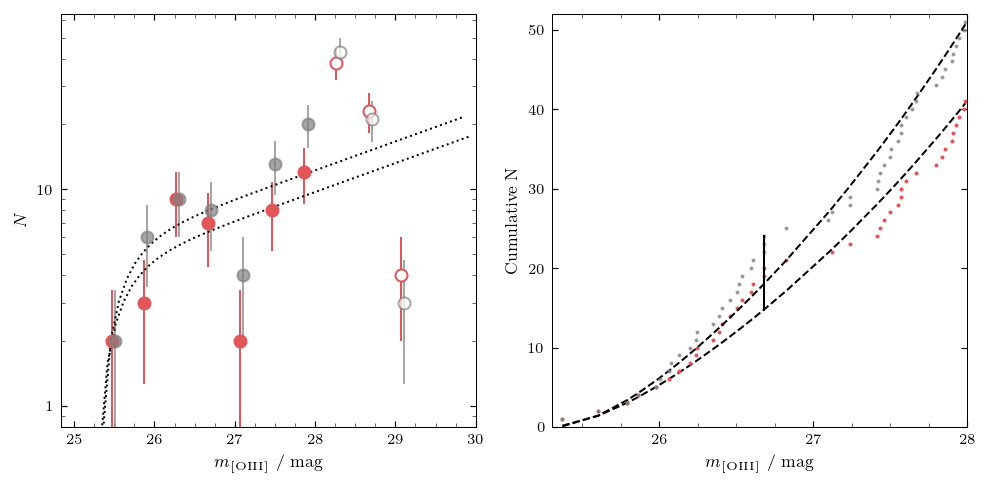

In [194]:
from pnlf.analyse import MaximumLikelihood1D, PNLF, pnlf
from pnlf.plot.pnlf import plot_pnlf

criteria1 = c_shape & (c_PN) & c_detec & ~tbl['exclude'] & ~tbl['overluminous']
data1 = tbl[np.where(c_limit & criteria1)]['mOIII']
err1  = tbl[np.where(c_limit & criteria1)]['dmOIII']

criteria2 = c_shape & (c_PN|c_SNR)  & c_detec & ~tbl['exclude'] & ~tbl['overluminous']
data2 = tbl[np.where(c_limit & criteria2)]['mOIII']
err2  = tbl[np.where(c_limit & criteria2)]['dmOIII']

print(f'{galaxy.name}: literature {galaxy.mu:.3f}')
print(f'completeness limit = {galaxy.completeness_limit}')

fitter = MaximumLikelihood1D(pnlf,data1,err=err1,mhigh=galaxy.completeness_limit)
mu1,dp1,dm1 = fitter([28])
dp1 = np.sqrt(dp1**2+np.nanmean(err1)**2+dPSF**2)
dm1 = np.sqrt(dm1**2+np.nanmean(err1)**2+dPSF**2)
fitter = MaximumLikelihood1D(pnlf,data2,err=err2,mhigh=galaxy.completeness_limit)
mu2,dp2,dm2 = fitter([28])
dp2 = np.sqrt(dp2**2+np.nanmean(err2)**2+dPSF**2)
dm2 = np.sqrt(dm2**2+np.nanmean(err2)**2+dPSF**2)

print(f'plotting result for {galaxy.name} (binsize={binsize})')
filename = basedir / 'reports' / galaxy.name / f'{galaxy.name}_PNLF_with_SNR'
axes = plot_pnlf(tbl[criteria1]['mOIII'],mu1,galaxy.completeness_limit,binsize=binsize,mhigh=30,color=tab10[0])
axes = plot_pnlf(tbl[criteria2]['mOIII'],mu2,galaxy.completeness_limit,binsize=binsize,mhigh=30,filename=filename,color='grey',alpha=0.7,axes=axes)
plt.show()

### Calculate bolometric lumionsity

https://en.wikipedia.org/wiki/Apparent_magnitude

https://en.wikipedia.org/wiki/AB_magnitude

https://archive.is/20121204144725/http://www.astro.utoronto.ca/~patton/astro/mags.html#selection-161.0-161.27

https://www.stsci.edu/ftp/instrument_news/WFPC2/Wfpc2_phot/wfpc2_cookbook.html

use zeropoints from here (page 13): 

http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/magsystems.pdf

In [195]:
import astropy.constants as c

def V_band_to_bolometric(flux):
    '''Convert V-band flux to Lbol
    
    Parameters
    ----------
    flux : flux in erg/s/cm2/AA
    '''
    
    # we can (roughly) convert this to erg / s / cm^2 / Hz via
    F_nu = ((550*u.nm)**2/c.c * flux).to(u.erg / (u.s*u.cm**2*u.Hz))

    # define zero point in different units
    V0_lam = 363.1e-11 * u.erg / (u.s*u.cm**2*u.AA)
    V0_nu  = 3.64e-20 * u.erg / (u.s*u.cm**2*u.Hz)
    B0_lam = 632e-11 * u.erg / (u.s*u.cm**2*u.AA)
    B0_nu  = 4.26e-20 * u.erg / (u.s*u.cm**2*u.Hz)

    AV = 0

    # bolometric correction
    BC_V = -0.85
    BC_B = -1.5

    mV = -2.5*np.log10(flux/V0_lam)
    mV_nu  = -2.5*np.log10(F_nu/V0_nu)

    MV = mV - results.loc[name]['(m-M)'] - AV

    Lbol = 10**(-0.4*(MV-4.79)) * 10**(-0.4*(BC_V+0.07)) * u.Lsun
    
    return Lbol
    
def get_bolometric_luminosity(V_band,mask=None):

    if not isinstance(mask,np.ndarray):
        mask = np.zeros_like(V_band)

    # from the DAP we have the spectral flux density in erg / s / cm^2 / AA
    F_lam = np.nansum(V_band[~mask])*1e-20 * u.erg / (u.s*u.cm**2*u.AA)
    
    Lbol = V_band_to_bolometric(F_lam)

    return Lbol

with fits.open(data_raw/'AUXILIARY'/'Johnson'/ name / f'{name}_IMAGE_FOV_Johnson_V_WCS_Pall_mad.fits') as hdul:
    V_band = hdul[1].data
    V_band_header = hdul[1].header
        
Lbol = get_bolometric_luminosity(V_band,mask)

In [196]:
from pnlf.analyse import N25
import datetime
date = datetime.date.today().strftime('%Y.%m.%d')

NPN25 = N25(mu1,galaxy.completeness_limit,data1,2.5)

row = [name,
       date,
       np.sum(criteria & c_limit),
       NPN25,
       np.sum(c_shape & (tbl['type']=='SNR') & c_limit),
       np.sum(c_shape & c_SNR & c_limit),
       np.sum(tbl['exclude']),
       Lbol/u.Lsun,
       np.log10(NPN25/Lbol*u.Lsun),
       mu1,dp1,dm1,
       mu2,dp2,dm2,
       Distance(distmod=mu1).to(u.Mpc).value,
       np.sum(~mask),
       ks,pv
       ]

results.loc[name] = row

# save results to output table
for col in results.colnames[2:]:
    if col.startswith('N_'):
        results[col].info.format = '%.0f'
    else:
        results[col].info.format = '%.3f'
results['Lbol'].info.format = '%.2e'    
    
with open(basedir/'data'/'interim'/ 'results.txt','w',newline='\n') as f:
    ascii.write(results,f,format='fixed_width_two_line',overwrite=True,delimiter_pad=' ',position_char='=')

In [ ]:
# save results to output table
for col in results.colnames[2:]:
    if col.startswith('N_'):
        results[col].info.format = '%.0f'
    else:
        results[col].info.format = '%.3f'
        
results['err+d/Mpc'] = 2*np.log(10)*10**(results['(m-M)']/5) * results['err+(m-M)'] / 1e6
results['err-d/Mpc'] = 2*np.log(10)*10**(results['(m-M)']/5) * results['err-(m-M)'] / 1e6

with open(basedir/'data'/'interim'/ 'PHANGS_PNLF_distances.txt','w',newline='\n') as f:
    ascii.write(results[['name','date','(m-M)','err+(m-M)','err-(m-M)','d/Mpc','err+d/Mpc','err-d/Mpc']],f,format='fixed_width_two_line',overwrite=True,delimiter_pad=' ',position_char='=')

## Compare to stellar mass density

In [ ]:
from photutils import EllipticalAnnulus
from regions import PixCoord,EllipseAnnulusPixelRegion,EllipsePixelRegion

sample_table = ascii.read(basedir/'data'/'interim'/'sample.txt')
sample_table.add_index('Name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])

In [ ]:
x,y = sample_table.loc[name]['SkyCoord'].to_pixel(galaxy.wcs)
angle = sample_table.loc[name]['posang']
eccentricity = np.sin(sample_table.loc[name]['Inclination']*u.deg).value
r25 = sample_table.loc[name]['r25']

criteria = c_shape & (c_PN) & c_detec & ~tbl['exclude'] & ~tbl['overluminous']
data = tbl[np.where(criteria & c_limit)]

In [ ]:
data = tbl[np.where(criteria & c_limit)]

def sort_elliptical_bins(positions,center,eccentricity=1,angle=0*u.deg,n_per_bin=10):

    bins = []
    radius = []
    
    r_in  = 0
    r_out = 5
    found = 0
    
    while True:
        
        if r_in==0:
            aperture = EllipsePixelRegion(center,
                                         width=r_out,
                                         height=np.sqrt((r_out)**2 * (1-eccentricity**2)),
                                         angle=angle)
        else:
            aperture = EllipseAnnulusPixelRegion(center,
                                         inner_width  = r_in,
                                         inner_height = np.sqrt((r_in)**2 * (1-eccentricity**2)),
                                         outer_width  = r_out,
                                         outer_height = np.sqrt(r_out**2 * (1-eccentricity**2)),
                                         angle=angle)
        
        N = np.sum(aperture.contains(positions))

        if N>n_per_bin or N+found>=len(positions):
            found += N
            r_in  = r_out
            r_out = r_in+5
            bins.append(aperture)
            radius.append((r_in+r_out)/2)
        else:
            r_out+=1
                                                 
        if found>=len(positions):
            print('all objects found')
            break
        if r_out>1.4*np.max(galaxy.whitelight.shape):
            print('maximum radius reached')
            break
            
    return bins, np.array(radius)

bins, radius = sort_elliptical_bins(
                                    positions=PixCoord(data['x'],data['y']),
                                    center=PixCoord(x,y),
                                    eccentricity=eccentricity,
                                    angle=angle*u.deg,
                                    n_per_bin=20,
                                    )

In [ ]:
def measure_radial(bins,radius,positions,data):
    
    data = data.copy()
    
    fig = plt.figure(figsize=(two_column,two_column/2))
    ax1 = fig.add_subplot(121,projection=galaxy.wcs)
    ax2 = fig.add_subplot(122)
    ax3 = ax2.twinx()
    
    norm = simple_norm(data,'linear',clip=False,max_percent=95)
    ax1.imshow(data,norm=norm,cmap=plt.cm.Greens_r)
    
    count = []
    mass  = []
    area  = []
    Lbol  = []
    
    dummy = np.zeros_like(data)
    dummy[~np.isnan(data)] = 1
    data[np.isnan(data)] = 0

    for aperture,r in zip(bins,radius):

        patch = aperture.as_artist(facecolor='none', edgecolor='black', lw=1,ls='--')
        ax1.add_patch(patch)
        
        count.append(np.sum(aperture.contains(positions)))
        mass.append(np.sum(aperture.to_mask().multiply(data)))
        flux = np.sum(aperture.to_mask().multiply(data))*1e-20 * u.erg / (u.s*u.cm**2*u.AA)
        Lbol.append(V_band_to_bolometric(flux))
        #area.append(np.sum(aperture.to_mask().multiply(dummy)))
        area.append(aperture.area)
        
    count = np.array(count)
    mass = np.array(mass)
    area = np.array(area)
    Lbol = np.array([L/u.Lsun for L in Lbol])
    
    ax2.scatter(radius/5,count/area,color=tab10[0])
    ax3.scatter(radius/5,Lbol/area,color=tab10[1])
    
    ax2.set(xlabel='radius / arcsec',ylim=[min(count/area)*0.8,max(count/area)*1.2],yscale='log')
    ax2.set_ylabel(ylabel=r'$N_{PN} / arcsec^2$',color=tab10[0])
    ax2.tick_params(axis='y', labelcolor=tab10[0])
    
    ax3.set(ylim=[min(Lbol/area)*0.8,max(Lbol/area)*1.2],yscale='log')
    ax3.set_ylabel(ylabel='flux / $arcsec^2$',color=tab10[1])
    ax3.tick_params(axis='y', labelcolor=tab10[1])

    plt.tight_layout()
    plt.savefig(basedir/'reports'/galaxy.name/f'{galaxy.name}_PN_profile.pdf')
    plt.show()
    
    return count,mass,area
 
count,mass,area = measure_radial(bins[2:],radius[2:],positions=PixCoord(data['x'],data['y']),data=galaxy.whitelight)

## Look at spectrum

In [ ]:
from pnlf.plot.spectrum import spectrum_and_rgb

filename = data_ext / 'MUSE' / 'DR1' / 'MOSAIC' / name / f'{name}_DATACUBE_FINAL.fits'

with fits.open(filename , memmap=True, mode='denywrite') as hdul:
    data_cube   = hdul[1].data
    cube_header = hdul[1].header

In [ ]:
from spectral_cube import SpectralCube

In [ ]:
filename = data_ext / 'MUSE' / 'DR1' / 'MOSAIC' / name / f'{name}_DATACUBE_FINAL.fits'
cube = SpectralCube.read(filename,format='fits',hdu='DATA',memmap=True, mode='denywrite')

In [ ]:
from regions import CircleSkyRegion

In [ ]:
region = CircleSkyRegion(pn['SkyCoord'], 5*u.arcsecond)

subcube = cube.subcube_from_regions([region])

In [ ]:
subcube.write(f'{galaxy.name}_{pn["id"]}.fits')

In [ ]:
tbl.sort(['mOIII'])
pn = tbl[tbl['id']==1266][0]

print(f'ID: {pn["id"]}, mOIII={pn["mOIII"]:.2f}')
filename = basedir / 'reports' / 'spectra' / f'{galaxy.name}_{pn["id"]}.pdf'
spectra,wavelength = spectrum_and_rgb(pn['SkyCoord'],galaxy,data_cube,galaxy.wcs,aperture_size=1.5,filename=filename)


## Compare to existing Studies

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)
from astropy.table import vstack

from pnlf.load_references import NGC628, \
                                   pn_NGC628_kreckel, \
                                   snr_NGC628_kreckel, \
                                   pn_NGC628_herrmann, \
                                   NGC628_kreckel, \
                                   pn_NGC5068_herrmann, \
                                   pn_NGC3351_ciardullo, \
                                   pn_NGC3627_ciardullo


def get_fwhm(x,y):
    try:
        return galaxy.PSF[int(y),int(x)]
    except:
        return 0

for table in [NGC628,pn_NGC628_kreckel,snr_NGC628_kreckel,NGC628_kreckel,
              pn_NGC628_herrmann,pn_NGC5068_herrmann,pn_NGC3351_ciardullo,pn_NGC3627_ciardullo]:
    table['x'],table['y']= table['SkyCoord'].to_pixel(wcs=galaxy.wcs)
    table['fwhm'] = np.array([get_fwhm(x,y) for x,y in zip(table['x'],table['y'])])


exclude objects that lie outside our field of view

In [ ]:
# select the correct catalogue here
matchcoord = NGC628

catalogcoord = tbl[tbl['mOIII']<galaxy.completeness_limit].copy()
#catalogcoord['SkyCoord'] = 

matchcoord['in_frame'] = False
y_dim,x_dim = galaxy.shape

for row in matchcoord:
    x,y = row['x'], row['y']    
    if 0<=int(x)<x_dim and 0<=int(y)<y_dim:
        if not np.isnan(galaxy.PSF[int(y),int(x)]):
            row['in_frame'] = True
           
print(f"{np.sum(~matchcoord['in_frame'])} objects outside of our field of view")
matchcoord   = matchcoord[matchcoord['in_frame'] & (matchcoord['mOIII']<27.5)]

plot the detections from the paper and our own detections

In [ ]:
fig = plt.figure(figsize=(single_column,single_column))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Greens)

ax1.scatter(matchcoord['x'],matchcoord['y'],marker='o',s=6,lw=0.2,edgecolor='tab:red',facecolors='none')
ax1.scatter(catalogcoord['x'],catalogcoord['y'],marker='o',s=6,lw=0.2,edgecolor='tab:orange',facecolors='none')

for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')

plt.savefig(basedir / 'reports' / galaxy.name /f'{galaxy.name}_PN_position_comparison.pdf',dpi=600)

see how many match within 1"

In [ ]:
tolerance = '0.5"'
ID, angle, Quantity  = match_coordinates_sky(matchcoord['SkyCoord'],SkyCoord.from_pixel(catalogcoord['x'],catalogcoord['y'],galaxy.wcs))
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle[angle.__lt__(Angle(tolerance))].mean().to_string(u.arcsec,decimal=True)}')

### Compare [OIII] and H$\alpha$ fluxes

In [ ]:
def compare_OIII_fluxes():
    #mpl.use('pgf')
    #plt.style.use('../src/pymuse/TeX.mplstyle')
    
    mpl.rcParams['pgf.preamble'] = [r'\usepackage[hidelinks]{hyperref}', ]
    
    matchcoord['mOIII_measured'] = catalogcoord[ID]['mOIII']
    matchcoord['dmOIII_measured'] = catalogcoord[ID]['dmOIII']
    
    crit = angle.__lt__(Angle("0.5s"))

    fig,ax = plt.subplots(figsize=(single_column,single_column))

    color=tab10[0]
    for s in ['Kreckel PN','Kreckel SNR','Herrmann PN']:
        color = next(ax._get_lines.prop_cycler)['color']
        tmp = matchcoord[(matchcoord['source']==s) & crit]
        plt.errorbar(tmp['mOIII'],tmp['mOIII_measured'],
                     yerr = tmp['dmOIII_measured'],
                     marker='o',ms=2,ls='none',mec=color,mfc=color,ecolor=color,label=s)

    #plt.errorbar(matchcoord[crit]['mOIII'],matchcoord[crit]['mOIII_measured'],
    #             yerr = matchcoord[crit]['dmOIII_measured'],
    #             marker='o',ms=4,ls='none',mec=color,mfc=color,ecolor=color,label=s)

        
    base_url = 'https://ui.adsabs.harvard.edu/abs/'
    link = f'\href{{{base_url + matchcoord.meta["bibcode"]}}}{{{matchcoord.meta["reference"]}}}'

    xmin = np.floor(2*np.min(matchcoord['mOIII']))/2
    xmax = np.ceil(2*np.max(matchcoord['mOIII']))/2
    ymin = np.floor(2*np.min(matchcoord['mOIII_measured']))/2
    ymax = np.ceil(2*np.max(matchcoord['mOIII_measured']))/2
    
    plt.plot([xmin,xmax],[xmin,xmax],color='black',lw=0.4)
    #plt.plot([xmin,xmax],[xmin-0.5,xmax-0.5],color='gray',lw=0.5,ls='--')
    #plt.plot([xmin,xmax],[xmin+0.5,xmax+0.5],color='gray',lw=0.5,ls='--')
    #ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$' + f' {link}')
    ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{O}\,\tiny{\textsc{iii}}]}$ existing studies')
    ax.set_ylabel(r'$\mathrm{m}_{[\mathrm{O}\,\tiny{\textsc{iii}}]}$ this work')
    #ax.set(xlim=[xmin,xmax],ylim=[xmin,xmax])
    plt.legend()
    
    plt.savefig(basedir / 'reports' / f'flux_comparison_OIII2.pdf',dpi=600)
    plt.show()
    
compare_OIII_fluxes()

In [ ]:
def compare_HA_fluxes():
    
    #mpl.use('pgf')
    #plt.style.use('TeX.mplstyle')
    
    mpl.rcParams['pgf.preamble'] = [r'\usepackage[hidelinks]{hyperref}', ]
    
    catalogcoord['R2'] = catalogcoord['OIII5006'] / (catalogcoord['HA6562']+catalogcoord['NII6583'])
    catalogcoord['dR2'] = catalogcoord['R2']  * np.sqrt(catalogcoord['OIII5006_err']/catalogcoord['OIII5006_err']**2 + 1/(catalogcoord['HA6562']+catalogcoord['NII6583'])**2 * (catalogcoord['HA6562_err']**2+catalogcoord['NII6583_err']**2) )                                  
    
    matchcoord['R_measured'] = catalogcoord[ID]['R2']
    matchcoord['dR_measured'] = catalogcoord[ID]['dR2']

    crit = angle.__lt__(Angle("1s"))

    fig,ax = plt.subplots(figsize=(single_column,single_column))

    color=tab10[0]
    for s in ['Kreckel PN','Kreckel SNR','Herrmann PN']:
        color = next(ax._get_lines.prop_cycler)['color']
        tmp = matchcoord[(matchcoord['source']==s) & crit]
        print(f"{s}: {np.sum(tmp['R'] > tmp['R_measured']) / len(tmp) * 100:.2f} % under")
        plt.errorbar(tmp['R'],tmp['R_measured'],
                     #xerr = tmp['dR'],
                     #yerr = tmp['dR_measured'],
                     marker='o',ms=2,ls='none',mec=color,mfc=color,ecolor=color,label=s)

    xmin,xmax = 0,7
    ymin,ymax = 0,7
    
    plt.plot([xmin,xmax],[xmin,xmax],color='black',lw=0.4)
    #plt.plot([xmin,xmax],[xmin-0.5,xmax-0.5],color='gray',lw=0.5,ls='--')
    #plt.plot([xmin,xmax],[xmin+0.5,xmax+0.5],color='gray',lw=0.5,ls='--')
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    #ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$' + f' {link}')
    ax.set_xlabel(r'$I_{[\mathrm{O}\,\tiny{\textsc{iii}}]}\;/\;(I_{\mathrm{H}\,\alpha}+I_{[\mathrm{N}\,\tiny{\textsc{ii}}]})$ existing studies')
    ax.set_ylabel(r'$I_{[\mathrm{O}\,\tiny{\textsc{iii}}]}\;/\;(I_{\mathrm{H}\,\alpha}+I_{[\mathrm{N}\,\tiny{\textsc{ii}}]})$ this work')
    plt.legend(loc=2)
    
    
    plt.savefig(basedir / 'reports' / f'flux_comparison_HA.pdf',dpi=600)
    
    plt.show()
    
catalogcoord = tbl[tbl['mOIII']<galaxy.completeness_limit]
compare_HA_fluxes()

### Francesco's Nebula catalogue

In [ ]:
# new catalogue
with fits.open(data_raw /'AUXILIARY'/'Nebulae catalogue' / 'Nebulae_Catalogue.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae=nebulae[(nebulae['gal_name']==galaxy.name) & (nebulae['flag_point_source']==2)]
nebulae['SkyCoord'] = SkyCoord.from_pixel(nebulae['cen_x'],nebulae['cen_y'],galaxy.wcs)
nebulae['mOIII'] = -2.5*np.log10(nebulae['OIII5006_FLUX']*1e-20) - 13.74
nebulae=nebulae[nebulae['mOIII']<galaxy.completeness_limit]

In [ ]:
with fits.open(basedir / 'data' / 'external' / 'nebula_catalogue_FS_v01.fits') as hdul:
    nebula_catalogue = Table(hdul[1].data)
    
PNe_candidate = nebula_catalogue[(nebula_catalogue['gal_name']==galaxy.name) & (nebula_catalogue['PNe_candidate']==1)]
PNe_candidate['SkyCoord'] = SkyCoord.from_pixel(PNe_candidate['cen_x'],PNe_candidate['cen_y'],galaxy.wcs)

In [ ]:
tolerance = '0.8"'
ID, angle, Quantity  = match_coordinates_sky(PNe_candidate['SkyCoord'],tbl['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'I recover {within_tolerance} of Francescos {len(angle)} sources')

In [ ]:
ID, angle, Quantity  = match_coordinates_sky(nebulae['SkyCoord'],tbl['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'Search in Francescos catalogue: {within_tolerance} of {len(angle)} of  match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')


In [ ]:
from photutils import CircularAperture

with fits.open(basedir / 'data' / 'external' / 'nebula_catalogue_FS_v01.fits') as hdul:
    nebula_catalogue = Table(hdul[1].data)

# (nebula_catalogue['region_size_pixels']<100) &
PNe_candidate = nebula_catalogue[(nebula_catalogue['gal_name']==galaxy.name) & (nebula_catalogue['PNe_candidate']==1)]
print(f'{len(PNe_candidate)} candidates from FS')

fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(projection=galaxy.wcs)
norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Greens)

cat = tbl[c_PN & c_limit]

#positions = np.transpose([PNe_candidate['cen_x'],PNe_candidate['cen_y']])
#apertures = CircularAperture(positions, r=6)
ax.scatter(PNe_candidate['cen_x'],PNe_candidate['cen_y'],marker='o',s=5,lw=0.4,edgecolor='red',facecolors='none')
ax.scatter(cat['x'],cat['y'],marker='o',s=5,lw=0.4,edgecolor='blue',facecolors='none')

#apertures.plot(color='red',lw=.2, alpha=1)
plt.savefig(basedir / 'reports' / f'{galaxy.name}_FS_comparison.pdf',dpi=600)

In [ ]:
data = -2.5*np.log10(PNe_candidate['OIII5006_FLUX']*1e-20) - 13.74

fitter = MaximumLikelihood1D(pnlf,
                             data[data<28],
                             mhigh=galaxy.completeness_limit)
mu,dp,dm = fitter([24])
print(f'literature: {galaxy.mu:.2f}')
axes = plot_pnlf(data,
                 mu,
                 galaxy.completeness_limit,
                 binsize=0.4,
                 mhigh=30,
                 color=tab10[0])


### Enrico's Catalogue

In [ ]:
with fits.open(basedir / 'data' / 'external' / 'clumpfind_cat_v02.fits') as hdul:
    nebula_catalogue = Table(hdul[1].data)
nebula_catalogue = nebula_catalogue[(nebula_catalogue['gal_name']==galaxy.name)]

In [ ]:
from photutils import CircularAperture

with fits.open(basedir / 'data' / 'external' / 'clumpfind_cat_v02.fits') as hdul:
    nebula_catalogue = Table(hdul[1].data)
nebula_catalogue = nebula_catalogue[(nebula_catalogue['gal_name']==galaxy.name)]

nebula_catalogue.rename_column('cen_x','x')
nebula_catalogue.rename_column('cen_y','y')
nebula_catalogue = nebula_catalogue[~np.isnan(nebula_catalogue['x']) & ~np.isnan(nebula_catalogue['y'])]
nebula_catalogue['fwhm'] = np.array([galaxy.PSF[int(y),int(x)] for x,y in zip(nebula_catalogue['x'],nebula_catalogue['y'])])
nebula_catalogue['SkyCoord'] = SkyCoord.from_pixel(nebula_catalogue['x'],nebula_catalogue['y'],galaxy.wcs)
nebula_catalogue['mOIII'] = -2.5*np.log10(nebula_catalogue['OIII5006_FLUX']*1e-20) - 13.74


In [ ]:
ID, angle, Quantity  = match_coordinates_sky(nebula_catalogue['SkyCoord'],tbl['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} of  match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')


In [ ]:
nebula_catalogue['FHA'] = tbl[ID]['HA6562']

In [ ]:
match = nebula_catalogue[angle.__lt__(Angle(tolerance))]
plt.scatter(match['HA6562_FLUX'],match['FHA'])
plt.plot([0,1e6],[0,1e6])

#### Use flux measurements from Enrico

In [ ]:
for col in nebula_catalogue.colnames:
    if col.endswith('_FLUX'):
        nebula_catalogue.rename_column(col,col[:-5])
    if col.endswith('_FLUX_ERR'):
        nebula_catalogue.rename_column(col,col[:-9]+'_err')
        
nebula_catalogue['mOIII'] = -2.5*np.log10(nebula_catalogue['OIII5006']*1e-20) - 13.74
nebula_catalogue['dmOIII'] = np.abs( 2.5/np.log(10) * nebula_catalogue['OIII5006_err'] / nebula_catalogue['OIII5006'])

nebula_catalogue = emission_line_diagnostics(nebula_catalogue,galaxy.mu,galaxy.completeness_limit) 
pn_candidates = nebula_catalogue[nebula_catalogue['type']=='PN']

#### Measure flux with background subtraction

In [ ]:
flux = measure_flux(galaxy,
                    nebula_catalogue,
                    alpha=galaxy.alpha,
                    Rv=3.1,
                    Ebv=0.062,
                    extinction='MW',
                    aperture_size=1.5)

# calculate magnitudes from measured fluxes
flux['mOIII'] = -2.5*np.log10(flux['OIII5006']*1e-20) - 13.74
flux['dmOIII'] = np.abs( 2.5/np.log(10) * flux['OIII5006_err'] / flux['OIII5006'] )

emd = emission_line_diagnostics(flux,galaxy.mu,galaxy.completeness_limit) 
pn_candidates = emd[(emd['type']=='PN') & (emd['mOIII']<28)]


#### Visualize the result

In [ ]:
print(f'{len(pn_candidates)} nebulae from Enrico')

fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Greens)

cat = tbl[c_PN & c_limit]

#positions = np.transpose([PNe_candidate['cen_x'],PNe_candidate['cen_y']])
#apertures = CircularAperture(positions, r=6)
ax.scatter(pn_candidates['x'],pn_candidates['y'],marker='o',s=4,lw=0.4,edgecolor='tab:orange',facecolors='none')
ax.scatter(cat['x'],cat['y'],marker='o',s=6,lw=0.4,edgecolor='tab:blue',facecolors='none')

#apertures.plot(color='red',lw=.2, alpha=1)
plt.savefig(basedir / 'reports' / f'{galaxy.name}_Enrico_comparison.pdf',dpi=600)

In [ ]:
from astropy.coordinates import match_coordinates_sky

matchcoord   = pn_candidates
matchcoord['SkyCoord'] = SkyCoord.from_pixel(matchcoord['x'],matchcoord['y'],galaxy.wcs)
cat['SkyCoord'] = SkyCoord.from_pixel(cat['x'],cat['y'],galaxy.wcs)

tolerance = '2s'
ID, angle, Quantity  = match_coordinates_sky(matchcoord['SkyCoord'],cat['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle[angle.__lt__(Angle(tolerance))].mean().to_string(u.arcsec,decimal=True)}"')

In [ ]:
fitter = MaximumLikelihood1D(pnlf,
                             pn_candidates[(pn_candidates['mOIII']<28) & (pn_candidates['mOIII']>10)]['mOIII'],
                             mhigh=galaxy.completeness_limit)
mu,dp,dm = fitter([24])
print(f'literature: {galaxy.mu:.2f}')
axes = plot_pnlf(pn_candidates['mOIII'],
                 mu,
                 galaxy.completeness_limit,
                 binsize=0.4,
                 mhigh=30,
                 color=tab10[0])


## PSF stuff

In [ ]:
from pnlf.photometry import measure_single_flux

x,y,fwhm = tbl[tbl['id']==67][['x','y','fwhm']][0]

def compare_fwhm(x,y,fwhm):
    
    alpha = galaxy.power_index
    gamma = fwhm/(2*np.sqrt(2**(1/alpha)-1))
    f0 = measure_single_flux(galaxy.OIII5006,[x,y],3.5,alpha,gamma)

    fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(12,2.5))
    axes_iter = iter(axes.flatten())

    for dfwhm in [-0.5,-0.25,0.0,0.25,0.5]:
        fwhm = 2 * gamma * np.sqrt(2**(1/alpha)-1) + dfwhm
        flux = []
        radii = np.arange(1,3.75,0.5)
        for aperture_size in radii:
            flux.append(measure_single_flux(galaxy.OIII5006,[x,y],aperture_size,alpha,fwhm/(2*np.sqrt(2**(1/alpha)-1))))
        flux=np.array(flux) 

        #print(f'{np.max(np.abs((flux[radii>=1.5]-f0)/f0*100)):.2f}')

        ax = next(axes_iter)
        ax.axvline(2,color='black',lw=0.8)
        ax.axhline(-1,color='black',lw=0.8)
        ax.axhline(1,color='black',lw=0.8)

        ax.plot(radii,(flux-flux[-1])/flux[-1]*100)

        ax.set_title(f'FWHM={fwhm:.2f}')
        ax.set(xlabel='aperture radius / fwhm',ylim=[-15,15])

    plt.tight_layout()
    plt.show()
    
for row in tmp[:5]:
    x,y,fwhm = row[['x','y','fwhm']]
    compare_fwhm(x,y,fwhm)

In [ ]:
mag = lambda f: -2.5*np.log10(f*1e-20) - 13.74
f0 = 5919
print(mag(f0)-mag(1.1*f0))


In [ ]:
from pnlf.auxiliary import light_in_moffat

aperture_size = 3
alpha = 2.3

gamma = fwhm / (2 * np.sqrt(2**(1/alpha)-1))
r = aperture_size * (fwhm) / 2 
light_in_moffat(r,alpha,gamma)

In [ ]:
from pnlf.auxiliary import light_in_moffat

fwhm = 4
aperture_size = np.arange(1,3.25,0.25)

fig, (ax1) = plt.subplots(ncols=1,figsize=(6,4))

for alpha in [2.3,2.8]:

    gamma = fwhm / (2 * np.sqrt(2**(1/alpha)-1))
    r = aperture_size * (fwhm) / 2 
    l = light_in_moffat(r,alpha,gamma)
    
    ax1.plot(aperture_size,l,label=r'$\alpha=$'+f'{alpha}')

ax1.grid()
ax1.legend()  
ax1.set(xlabel='aperture diameter / FWHM',ylabel='flux in aperture')



plt.show()

In [ ]:
# https://github.com/astropy/photutils/issues/558
from photutils.psf import IterativelySubtractedPSFPhotometry, BasicPSFPhotometry, DAOPhotPSFPhotometry
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [ ]:
fwhm = np.unique(tbl['fwhm'])[0]
tmp = tbl[(tbl['type']=='PN') & (tbl['fwhm']==fwhm) & (~tbl['exclude'])]
tmp.sort('mOIII')
pos = Table(names=['x_0', 'y_0'], data=[tmp['x'],tmp['y']])
pos['id'] = np.arange(1,len(pos)+1)

In [ ]:
from astropy.modeling.models import Moffat2D
from photutils.psf import prepare_psf_model

alpha = galaxy.power_index
gamma = fwhm / 2 /  np.sqrt(2**(1/alpha)-1)

psffunc = Moffat2D(amplitude=1, gamma=gamma, alpha=alpha, x_0=0, y_0=0)
psffunc.amplitude.fixed=True
psffunc.gamma.fixed=True
psffunc.alpha.fixed=True
psfmodel = prepare_psf_model(psffunc, xname='x_0', yname='y_0', fluxname=None) 

In [ ]:
photometry = BasicPSFPhotometry(group_maker     = DAOGroup(np.nanmax(galaxy.PSF)/2*5),
                                bkg_estimator   = MMMBackground(),
                                psf_model       = psfmodel,
                                fitter          = LevMarLSQFitter(),
                                fitshape        = (15,15),
                                aperture_radius = 1.1*fwhm)
result_tab = photometry(image=galaxy.OIII5006, init_guesses=pos)

In [ ]:
mean, median, std = sigma_clipped_stats(galaxy.OIII5006_DAP, sigma=3.0,maxiters=5,mask=~(galaxy.PSF==fwhm))

finder = DAOStarFinder(galaxy.threshold*std,fwhm=fwhm)

In [ ]:
photometry = IterativelySubtractedPSFPhotometry(
                                group_maker     = DAOGroup(np.nanmax(galaxy.PSF)/2*5),
                                bkg_estimator   = MMMBackground(),
                                psf_model       = psfmodel,
                                finder          = finder,
                                fitter          = LevMarLSQFitter(),
                                fitshape        = (11,11),
                                aperture_radius = 1.5*fwhm)
result_tab = photometry(image=galaxy.OIII5006, init_guesses=pos[0:10])

In [ ]:
photometry = DAOPhotPSFPhotometry(crit_separation = np.nanmax(galaxy.PSF)/2*5,
                                  threshold       = 150,
                                  fwhm            = fwhm,
                                  psf_model       = psfmodel,
                                  fitter          = LevMarLSQFitter(),
                                  fitshape        = (11,11),
                                  aperture_radius = fwhm*1.5)
result_tab = photometry(image=galaxy.OIII5006, init_guesses=pos[0:30])

In [ ]:
Rv  = 3.1
tmp = tbl[(tbl['type']=='PN') & (tbl['mOIII']<28.5)]
    
for aperture_size in [1,2,3]:
    
    fl = measure_flux(galaxy,
                        tmp,
                        alpha=galaxy.power_index,
                        Rv=Rv,
                        Ebv=galaxy.Ebv,
                        extinction='MW',
                        lines = ['OIII5006'],
                        background='local',
                        aperture_size=aperture_size)

    # calculate astronomical coordinates for comparison

    # calculate magnitudes from measured fluxes
    fl['mOIII'] = -2.5*np.log10(fl['OIII5006']*1e-20) - 13.74
    fl['dmOIII'] = np.abs( 2.5/np.log(10) * fl['OIII5006_err'] / fl['OIII5006'])
    
    plt.scatter(tmp['mOIII'],fl['OIII5006']/fl['OIII5006_err'],label=aperture_size)

plt.ylim([1,400])
plt.xlim([25.5,28.5])
plt.ylabel('S/N')
plt.xlabel('mOIII')
plt.yscale('log')
plt.legend()
plt.savefig('StoN.pdf',dpi=600)
plt.show()

## Distance in parsec

the measured distances are in the form of the distance modulus $\mu = m-M$ which is the difference between apparent and absolute magnitude. By defintion of the absolte magnitude, we can convert this number into a distance in pc
$$
d = 10^{\frac{\mu}{5}+1} = 10 \cdot \exp\left( \ln 10 \frac{\mu}{5} \right) \\
\delta d = \frac{\ln 10}{5} 10 \exp\left( \ln 10 \frac{\mu}{5} \right) \delta \mu = 0.2 \ln 10 \; d \; \delta \mu
$$

In [ ]:
def distance_modulus_to_parsec(mu,mu_err=np.array([])):
    
    d = 10 * np.exp(np.log(10)*mu/5)
    if len(mu_err) > 0:
        d_err = 0.2 * np.log(10) * d * mu_err
    print(f'd = ({d/1e6:.2f} + {d_err[0]/1e6:.2f} - {d_err[1]/1e6:.2f}) Mpc')
    
    return d, d_err

d,d_err = distance_modulus_to_parsec(30.033,np.array([0.014,0.015]))

In [ ]:
def area(mu,Npixel,inclination,**kwargs):
    '''Calculate the survey area from parameters
    
    one can also pass the parameter dict as
    area(**parameters[name])
    additional parameters will be ignored
    '''
    
    size_of_pixel = 0.2*u.arcsec

    distance = Distance(distmod=mu)
    pixel_area = (size_of_pixel/u.arcsec * distance/206265)**2
        
    return pixel_area.to(u.kpc**2) *Npixel / np.cos(inclination*u.deg)
    

area(**parameters['NGC0628'])

## Compare with SDSS

In [ ]:
from astroquery.skyview import SkyView
from reproject import reproject_interp
from skimage.measure import find_contours

In [ ]:
try:
    img = SkyView.get_images(galaxy.name,survey=['SDSSi','SDSSr','SDSSg'],height=10*u.arcmin,width=10*u.arcmin)
    print('using SDSS data')
except:
    img = SkyView.get_images(galaxy.name,survey=['Mellinger Red','Mellinger Green','Mellinger Blue'],height=10*u.arcmin,width=10*u.arcmin)
    print('using Mellinger')
    
r = img[0][0].data
g = img[1][0].data
b = img[2][0].data

rgb=create_RGB(r,g,b,percentile=[98,98,98],weights=[0.8,0.8,0.8])

muse_sdss, footprint = reproject_interp((galaxy.whitelight,galaxy.wcs),img[0][0].header)
contours = find_contours(footprint,level=0.5)

In [ ]:
fig=plt.figure(figsize=(single_column,single_column))
ax=fig.add_subplot(projection=WCS(img[0][0].header))
for cont in contours:
    ax.plot(cont[:,1],cont[:,0],color='red',lw=0.5)
ax.imshow(rgb)
ax.set(xlabel='R.A. (J2000)',ylabel='Dec. (J2000)')
plt.savefig(basedir/'reports'/galaxy.name/f'{galaxy.name}_SDSS.pdf',dpi=1000)
plt.show()

In [ ]:
with fits.open(galaxy.filename) as hdul:
    hdul.info()

In [ ]:
from astropy.nddata import Cutout2D

tmp = tbl[(tbl['type']=='PN') & (tbl['OIII5006_SIGMA']>100) & (tbl['mOIII']<28)]

row = tmp[3]
PN = Cutout2D(galaxy.HA6562_SIGMA, (row['x'],row['y']), u.Quantity((15, 15), u.pixel),wcs=galaxy.wcs)

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(PN.data)
fig.colorbar(im)
plt.show()

In [ ]:
# whitelight image
with fits.open(data_ext / 'HST' / name / 'white_light' / f'{name.lower()}_white_24rgb.fits') as hdul:
    hst_whitelight = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    hst_whitelight.data[hst_whitelight.data==0] = np.nan

In [ ]:
from astropy.nddata import Cutout2D

In [ ]:
cutout_hst  = Cutout2D(hst_whitelight.data,tmp[2]['SkyCoord'],size=4*u.arcsec,wcs=hst_whitelight.wcs)
cutout_muse = Cutout2D(galaxy.OIII5006,tmp[2]['SkyCoord'],size=6*u.arcsec,wcs=galaxy.wcs)

In [ ]:
fig = plt.figure(figsize=(10,5))

norm = simple_norm(cutout_hst.data,'linear',clip=False,percent=99)
ax1  = fig.add_subplot(121,projection=cutout_hst.wcs)
ax1.imshow(cutout_hst.data,norm=norm,cmap=plt.cm.gray_r)
ax1.scatter(*tmp[1]['SkyCoord'].to_pixel(cutout_hst.wcs),c='r',s=1)
ax1.scatter(*tmp[2]['SkyCoord'].to_pixel(cutout_hst.wcs),c='r',s=1)

norm = simple_norm(cutout_muse.data,'linear',clip=False,percent=99)
ax2  = fig.add_subplot(122,projection=cutout_muse.wcs)
ax2.imshow(cutout_muse.data,norm=norm,cmap=plt.cm.Greens)

plt.show()